In [ ]:
#mount google drive
from google.colab import drive
drive_path="/content/drive"
drive.mount(drive_path)
drive_folder = drive_path + "/MyDrive/dtm/"

Mounted at /content/drive


# Params and Init


In [ ]:
!pip -q install plyfile deepdiff
import re
import numpy as np
from progressbar import progressbar, ProgressBar
import sys, os
import cv2
import math
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

     |████████████████████████████████| 71kB 2.6MB/s 


In [ ]:
!git clone https://github.com/InigoMoreno/deep_ga
import sys
sys.path.append('/content/deep_ga')
%load_ext autoreload
%autoreload 2
%aimport deep_ga

Cloning into 'deep_ga'...
remote: Enumerating objects: 419, done.
remote: Counting objects: 100% (419/419), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 419 (delta 276), reused 419 (delta 276), pack-reused 0
Receiving objects: 100% (419/419), 438.96 KiB | 8.96 MiB/s, done.
Resolving deltas: 100% (276/276), done.


In [ ]:
!git -C /content/deep_ga/ pull

Already up to date.


In [ ]:
p={
  "resolution" : .5,                      # resolution of map [meters per pixel]
  "mapLength"  : 40,                    # size of one side of the map [meters]
  "minSlopeThreshold"  : 0.5,            # minimum slope to be counted [proportion]
  "maxNanPercentage"   : 5/100,           # maximum percentage of NaNs in a patch [%]
  "minSlopePercentage" : 10/100,          # minimum percentage of slope in a patch [%]
  "maxSlopePercentage" : 40/100,          # maximum percentage of slope in a patch [%]
  "stdPatchShift"          : 15,          # standard deviation of shift between to patches [m]
  "local_resolution" : .5,
  "local_mapLength"  : 40,
  "local_maxNanPercentage": 65/100,
  "local_global_minCcorr": 15/100,
   
}
p["mapLengthPixels"]=math.ceil(p["mapLength"]/p["resolution"])
p["local_mapLengthPixels"]=math.ceil(p["local_mapLength"]/p["local_resolution"])

# Dataset preparation

In [ ]:
dems=[]
gps=[]
processed_folder = os.path.join(drive_folder,"processed")
npz_files = [file for file in os.listdir(processed_folder) if re.match("\d+-\d+.npz",file)]
for file in progressbar(npz_files):
    file_path = os.path.join(drive_folder,"processed", file)
    with np.load(file_path) as data:
      dems.append(data["dems"])
      gps.append(data["state_dem"])

dems=np.concatenate(dems)
gps=np.concatenate(gps)

N,W,H=dems.shape

100% (18 of 18) |########################| Elapsed Time: 0:00:40 Time:  0:00:40


In [ ]:
ply_file=os.path.join(drive_folder,"minas_densified_point_cloud.ply")
global_dem , global_img, displacement = deep_ga.ply_to_image(ply_file,p["resolution"])

#Plot Traverses

100% (18 of 18) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


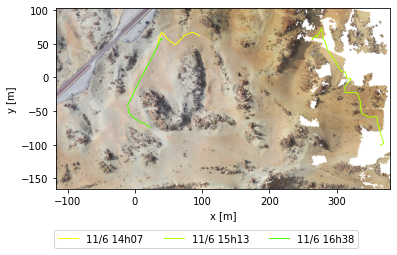

In [ ]:
plt.clf()
global_dem-=np.nanmin(global_dem)
W,H=global_dem.shape
r=p["resolution"]
img=global_img.transpose([1,0,2])/255
img=np.nan_to_num(img,nan=1)
dx=displacement[0]
dy=displacement[1]
plt.imshow(img,extent=(dx,dx+W*r,dy,dy+H*r), origin="lower")
max=np.nanmax(global_dem)
plt.xlabel("x [m]")
plt.ylabel("y [m]")

npz_files.sort()
N=len(npz_files)
lgd=[]
for i in progressbar(range(N)):
    filename = npz_files[i]
    day=int(filename[6:8])
    hour=int(filename[9:11])
    min=int(filename[11:13])
    file_path = os.path.join(drive_folder,"processed", filename)
    with np.load(file_path) as data:
      tgps=data["state_dem"]
      plt.plot(tgps[1::10,1],tgps[1::10,2],
                  linewidth=1,
                  color=matplotlib.colors.hsv_to_rgb((np.fmod(i/N+0.5,1),1,1)))
      lgd.append(f"{day:2}/6{hour:3}h{min:02}")

x=gps[:,1]
y=gps[:,2]
margin=10
plt.xlim((np.min(x)-margin,np.max(x)+margin))
plt.ylim((np.min(y)-margin,np.max(y)+margin))

plt.legend(lgd,loc='upper center', bbox_to_anchor=(0.45, -0.2),ncol=3)
# plt.savefig("tenerife_traverses.pdf", dpi=500, bbox_inches = 'tight',
    # pad_inches = 0)
plt.show();

# Filter data

In [ ]:
# crop dems to size
S=p["local_mapLengthPixels"]
if S<W:
  crop = (W-S)//2
  dems=dems[:,crop:-crop,:]
if S<H:
  crop = (H-S)//2
  dems=dems[:,:,crop:-crop]

N,W,H=dems.shape

# filter out values with a lot of NaN
nan_count=np.array([np.count_nonzero(np.isnan(dems[i,:,:]))/W/H for i in range(N)])
filter = nan_count < p["local_maxNanPercentage"]
dems=dems[filter]
gps=gps[filter]
print(f"Removing {np.mean(~filter)*100:.2f}% of dems due to too much NaN values")

N,W,H=dems.shape

# filter out values outside the global_dem
margin = p["mapLengthPixels"]/2
pixel_x=(-displacement[1] + gps[:,2]) / p["resolution"]
pixel_y=(-displacement[0] + gps[:,1]) / p["resolution"]
filter = (pixel_x>margin) 
filter &= (pixel_y>margin) 
filter &= (pixel_x<global_dem.shape[0]-margin) 
filter &= (pixel_y<global_dem.shape[0]-margin)

dems=dems[filter]
gps=gps[filter]
print(f"Removing {np.mean(~filter)*100:.2f}% of dems that were outside of the global dem")

N,W,H=dems.shape

In [ ]:
i=np.random.randint(N)
global_patch=deep_ga.get_patch(global_dem,gps[i,1],gps[i,2],p,displacement,True)
plt.subplot(1,2,1)
plt.imshow(np.transpose(global_patch))
plt.subplot(1,2,2)
plt.imshow(np.transpose(dems[i,:,:]))

In [ ]:
def get_slope(patch, resolution=1):
    slopeX = cv2.Sobel(patch, cv2.CV_32F, 1, 0, ksize=3)/resolution
    slopeY = cv2.Sobel(patch, cv2.CV_32F, 0, 1, ksize=3)/resolution
    slope = cv2.magnitude(slopeX, slopeY)
    return slope
    
ccorr=[]
global_none=[]
global_nan=[]
N,W,H=dems.shape
for i in progressbar(range(N)):
  local_dem=dems[i,:,:]
  global_patch=deep_ga.get_patch(global_dem,gps[i,1],gps[i,2],p,displacement,True)
  global_patch=global_patch.astype("float32")

  global_patch_None = deep_ga.get_patch(global_dem,gps[i,1],gps[i,2],p,displacement) is None
  
  nanPercentage = np.count_nonzero(np.isnan(global_patch))/p["mapLengthPixels"]**2

  local_slope = get_slope(local_dem.astype("float32"),p["resolution"])
  global_slope = get_slope(global_patch,p["resolution"])

  res = cv2.matchTemplate(np.nan_to_num(local_slope),np.nan_to_num(global_slope),cv2.TM_CCORR_NORMED)
  _, max_val, _, max_loc = cv2.minMaxLoc(res)

  ccorr.append(max_val)
  global_none.append(global_patch_None)
  global_nan.append(nanPercentage)




filter = np.array(ccorr)<p["local_global_minCcorr"]*100
dems=dems[filter]
gps=gps[filter]
print(f"Removing {np.mean(~filter)*100:.2f}% of dems due to too little correlation between local and global DEM")

filter = np.array(global_nan)<p["maxNanPercentage"]
dems=dems[filter]
gps=gps[filter]
print(f"Removing {np.mean(~filter)*100:.2f}% of dems due to too many NaNs in the global map")

# Save

In [ ]:
np.savez_compressed(os.path.join(drive_folder,"processed","filtered.npz"),dems=dems,gps=gps)